# 15-04-2025 Adapters & Hookers at Decoder Block of Llama

Methods in trailing the arseholes of these models

1. Hook the block / layer (e.g. attention block or q, k, v seperately, respectively)
    Ways to construct the *hooker*:
    - Hook as a function or 
    - Hook as a torch module so it whole heartedly deserves its own State Class Module (in saying that do not forget to delete the hook or deregister after you are done with it)

2. Create an Adapter which is similar to hookers except that it usually has its own learning architecture (e.g. mlp)

    Worthy notes:

    - Because it is a deep learning model, essentially you do not require to feature engineer. With that peace of mind, your only concern is asserting the right input / output across the layers / blocks. Other components include model output caches and general data visualisastions to stroke the monkeys viewing it
    - Unlike the *hookers*, there is only one clean way in constructing these Adapters. The usual target is the activation functions. 
    In usual machine learning concepts, theres a phase were you need to consider the optimization problem or sculpture the cost function you are minimizing / maximizing. In this case, you are using similar approach in constructing the activation functions for example RELU + Tanh = GELUTanh. Another core difference is that there is a `forward` pass in adapters whereas this feature is optional for hookers. (Good example: https://kevinmusgrave.github.io/pytorch-adapt/)


NOTE: This notebook uses 'SmolLM-135M' one of the few small instruct models. These are formerly instruct models and not entirely chat models 

Resource: 
https://huggingface.co/blog/smollm


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model="HuggingFaceTB/SmolLM-135M-Instruct")
pipe(messages)

Device set to use mps:0


[{'generated_text': [{'role': 'user', 'content': 'Who are you?'},
   {'role': 'assistant',
    'content': "I'm [Your Name]! I'm a software engineer at [Your Company/Organization]. I'm excited to share my passion for [specific topic or industry]. I'm always looking for ways to"}]}]

### Debrief - Intro to the model's architecture

In [10]:
# Quick overview of what we are dealing with - note that we have the model's head

pipe.model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb)

In [19]:
# An example of iterating across the stacks / layers

for i, layer in enumerate(pipe.model.model.layers):
    print(f"INDEX [{i}] --- {layer}")
    print(f"[-- ATTN BLOCK --]\n{layer.self_attn}") # can query layer.self_attn.q_proj to get q
    print(f"[-- MLP BLOCK --]\n{layer.mlp}")
    break

# Below should give the first indexed stack (out of 29 stacks)
# Its components is the Attention and MLP . There are 29 Attns and 29 mlps

INDEX [0] --- LlamaDecoderLayer(
  (self_attn): LlamaAttention(
    (q_proj): Linear(in_features=576, out_features=576, bias=False)
    (k_proj): Linear(in_features=576, out_features=192, bias=False)
    (v_proj): Linear(in_features=576, out_features=192, bias=False)
    (o_proj): Linear(in_features=576, out_features=576, bias=False)
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
    (up_proj): Linear(in_features=576, out_features=1536, bias=False)
    (down_proj): Linear(in_features=1536, out_features=576, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
)
[-- ATTN BLOCK --]
LlamaAttention(
  (q_proj): Linear(in_features=576, out_features=576, bias=False)
  (k_proj): Linear(in_features=576, out_features=192, bias=False)
  (v_proj): Linear(in_features=576, out_features=192, bias=False)
  (o_proj): Linear(in_features=576, out_features=576

### Analytics on the statistics of the model's architecture

In [56]:

import torch
import numpy as np
from collections import namedtuple

AttnStats = namedtuple('AttnStats', ['residual', 'mean', 'std', 'norm'], defaults=[0])

def get_stats(layer, prev = None):
    mu = layer.weight.mean().item()
    std = layer.weight.std().item()
    norm = layer.weight.norm().item()

    print(f"Mean: {mu} --- Std: {std} --- Norm: {norm}", end=" ")

    if prev is not None:
        loss = np.linalg.norm(prev - layer.weight.cpu().detach().numpy())
        print(f"-- residual: {loss}")
        return AttnStats(loss, mu, std, norm)
    else:
        print("-- residual: 0")
        return AttnStats(mu, std, norm)


In [57]:
# ATTN FOCUS ONLY
# weights shape [576, 576]

q_weight_blocks = []
k_weight_blocks = []
v_weight_blocks = []
o_weight_blocks = []

prev_q = None
prev_k = None
prev_v = None
prev_o = None

for i, layer in enumerate(pipe.model.model.layers):
    print(f"{'-'*20} INDEX [{i}] {'-'*20}")

    get_stats(layer.self_attn.q_proj, prev_q)
    get_stats(layer.self_attn.k_proj, prev_k)
    get_stats(layer.self_attn.v_proj, prev_v)
    get_stats(layer.self_attn.o_proj, prev_o)

    prev_q = layer.self_attn.q_proj.weight.cpu().detach().numpy()
    prev_k = layer.self_attn.k_proj.weight.cpu().detach().numpy()
    prev_v = layer.self_attn.v_proj.weight.cpu().detach().numpy()
    prev_o = layer.self_attn.o_proj.weight.cpu().detach().numpy()

assert len(q_weight_blocks) == len(k_weight_blocks) and len(k_weight_blocks) == len(v_weight_blocks) and len(v_weight_blocks) == len(o_weight_blocks), f"Different sizes detected, expected {i} length"

-------------------- INDEX [0] --------------------
Mean: -0.00045442176633514464 --- Std: 0.21280500292778015 --- Norm: 122.57577514648438 -- residual: 0
Mean: -0.0005649703671224415 --- Std: 0.32900816202163696 --- Norm: 109.41256713867188 -- residual: 0
Mean: 1.5420029740198515e-05 --- Std: 0.040442608296871185 --- Norm: 13.449280738830566 -- residual: 0
Mean: -7.776421625749208e-06 --- Std: 0.06442184746265411 --- Norm: 37.10692596435547 -- residual: 0
-------------------- INDEX [1] --------------------
Mean: 0.0006094734417274594 --- Std: 0.29774197936058044 --- Norm: 171.49948120117188 -- residual: 210.66424560546875
Mean: 0.0009046257473528385 --- Std: 0.33252739906311035 --- Norm: 110.58314514160156 -- residual: 155.37762451171875
Mean: -0.00046286932774819434 --- Std: 0.1470029354095459 --- Norm: 48.88640213012695 -- residual: 50.6690788269043
Mean: 0.00024094420950859785 --- Std: 0.16530662775039673 --- Norm: 95.21656799316406 -- residual: 102.30538177490234
-----------------

### Quick Demo on the basics of registering a hook on LLMs 

In [ ]:
import torch

def attn_block_hook_fn(module, input, output):
    # testing function to only hook on the q-key layer
    # Layer is the q_proj itself, input and output shape is (1, 1, 576)
    # NOTE: Hooking functions / modules will only run when you inference the model, not when you are registering the hookers

    print(f"[HOOK] Layer: {module} | Input shape: {input[0].shape} | Output shape: {output.shape}")
    return output

for i, layer in enumerate(pipe.model.model.layers):
    layer.self_attn.q_proj.register_forward_hook(attn_block_hook_fn)
    break


In [ ]:
# One way of viewing the hookers for the layer. This is probably a less clean way of presenting the hookers

layer.self_attn.q_proj._forward_hooks

OrderedDict([(0, <function __main__.q_hook_fn(module, input, output)>),
             (1,
              <function __main__.attn_block_hook_fn(module, input, output)>)])

### **Combining Concepts together**

The objective is to analyse the latent space and trial the following tools and features from huggingface: 

- **Hookers**
- **Decoder block args** e.g. input_embeds and caches 

**Notes**
```bash
use_cache (`bool`, *optional*):
    If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
    `past_key_values`).

```

In summary,

- when you set the use_cache=True, the past_key_values will automatically return
- There are two extra tools you can use here:
    1. Input embeds - customized embedded representation to convert input ids indices into vectors rather than using the model's internal embedding lookup matrix
    2. Cache position - Indices depicting the position of the input sequence tokens in the sequence. It does not get affected by padding and is used to `UPDATE THE CACHE` in the correct position and to infer the complete seqeunce length

- `past_key_values` is recursively inserted with past caches. So cache manipulation operations is done before you pass it back to the `past_key_values` with the new (and unseen) input_ids. Though, unsure on what happens if nothing is passed. Probably, will do nothing and the default KV ranking will be implemented

- **Resources**
    - https://huggingface.co/docs/transformers/en/kv_cache 
    - https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct?library=transformers

**Task Description**

*Objective*:
- No particular objective in application yet, and this will be more of a data exploration stage. 
- In saying that, random methods are implemented as I go forward even where theres no particular direction or intention 

*Environment Setup* 
Scattering my thoughts across options that has varied forms of its own can lead me to stray at times so its probably best to discipline my thought process by declaring unchanging features throughout my works (as a way of keeping me in line and not spiral down a rabbit hole). The unchanged focus includes:

- Different ways of implementing hookers (rather than adapters)
- Ways in manipulating the latent space of text generations will work around hookers functions / modules 
- Decoder output configurations like max sequence tokens, beam search parameters, .. etc will also remain unchanged for this case



**Background Notes** 

- `past_key_values` 
    - length 30 (== same number of blocks (30) in the transformer) and 
    - each row as key-value pairs (summary of KV cache: x_{t-1} -> x_{t})

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, DynamicCache

In [3]:
NUM_BLOCKS = 30  # len(model.model.layers)

# Setting up Hookers
class Hooker(torch.nn.Module):
    """
        Hooker State Manager Model that logs previous caches and hooked input/output.
        - Track what gets cached and when using a logger or visualizer.
        - Contains memory manipulation logic based on certain goals - persistence, forgetfulness, context bias etc
        - Add synthetic / curated memory into the KV store conditionally (this point helps the previous)

        Testing is comparison study - with/without memory system (and cognitive)
    """
    def __init__(self):
        super(Hooker, self).__init__()
        self.cache_output = [] # from the hooks outputs
        self.cache_input = [] # from the hooks inputs
        self.kv = [] # as past key values

    def forward_hook(self, module, input, output):
        """
        Custom Hook function. The Goal here is to manipulate the ranks of the logits via Attn blocks.

        >>> i want to implement an algorithm between these caches and attention blocks hooks to influence chat generations and memory retained in the language models in the chat session
        """

        print(f"[HOOKER] Module: {module.__class__.__name__} >>> Input {len(input)} && Output {len(output)}")

        # If len(input) == 0 and len(output) != 0 (the output.len is never 0?) then this implies the chat session begins. But we are going to fact check that anyway. Input and Output seems to only return len 2 when hooked over attn block
        if len(output) == 0:
            raise ValueError(f"Unexpected output type shape returned: {type(output)}")

        if output:
            self.cache_output += [output]

        if input:
            self.cache_input += [input]

        return output

    def attach_hooks(self, model):
        """ Attach hooks to models. """

        for i, layer in enumerate(model.model.layers):
            layer.self_attn.register_forward_hook(self.forward_hook)
            print(f"[HOOKER] Hook attached to layer {i} self_attn")

    def reset(self, model):
        """ Removes models hooks and resets. """

        for i, layer in enumerate(model.model.layers):
            layer.self_attn._forward_hooks.clear()
            print(f"[HOOKER] Hook attached to layer {i} self_attn")

        return model

    def update(self, past_key_values):
        """
        Updates fn during kvcaches during chat streams.
        Inputs `past_key_values` = prev caches + new token qkv.
        If `return_legacy_cache`=False, this model will return DynamicCache(), otherwise it will return tuple in default form.

        """
        # assert isinstance(past_key_values, tuple) and len(past_key_values) == NUM_BLOCKS, f"Unexpected input: {past_key_values}"
        # assert len(past_key_values[0]) == 2, f"Expected paired key-value inputs as past kv caches but received: {past_key_values[0]}"
        if isinstance(past_key_values, DynamicCache):
            # `update` Updates the cache with the new key_states and value_states for the layer layer_idx.
            self.kv += [past_key_values]
            print("Updated new kv cache !")
        else:
            print(f"No `past_key_values` could be appended. Received: {type(past_key_values)}")

def setup(model):
    """ Setup model for inferencing. """

    # 1. Checks the grad is false (train mode off) - Ensure its not on training mode (this is a slow method, should call `with torch.no_grad()` instead)
    for name, param in model.named_parameters():
        print(f"{name}: requires_grad = {param.requires_grad}")
        if param.requires_grad:
            param.requires_grad = False
            print(f"Layer {name}: requires_grad = {param.requires_grad} but turned off")

    # 2. Hooks functions onto the blocks - NOTE: no backward hooks because no back prop. passed
    hooker = Hooker()
    hooker.attach_hooks(model)

    print(f"Finished setting up model for inferencing and tuning :-)")
    return hooker, model

# Loads the model directly
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M-Instruct")
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-135M-Instruct")

# Set up model for inferencing
hooker, model = setup(model)

model.embed_tokens.weight: requires_grad = True
Layer model.embed_tokens.weight: requires_grad = False but turned off
model.layers.0.self_attn.q_proj.weight: requires_grad = True
Layer model.layers.0.self_attn.q_proj.weight: requires_grad = False but turned off
model.layers.0.self_attn.k_proj.weight: requires_grad = True
Layer model.layers.0.self_attn.k_proj.weight: requires_grad = False but turned off
model.layers.0.self_attn.v_proj.weight: requires_grad = True
Layer model.layers.0.self_attn.v_proj.weight: requires_grad = False but turned off
model.layers.0.self_attn.o_proj.weight: requires_grad = True
Layer model.layers.0.self_attn.o_proj.weight: requires_grad = False but turned off
model.layers.0.mlp.gate_proj.weight: requires_grad = True
Layer model.layers.0.mlp.gate_proj.weight: requires_grad = False but turned off
model.layers.0.mlp.up_proj.weight: requires_grad = True
Layer model.layers.0.mlp.up_proj.weight: requires_grad = False but turned off
model.layers.0.mlp.down_proj.weigh

In [4]:
# defining the input features (besides the input_ids and embeddings of the input chat)

output_config = dict(
    use_cache=True,
    output_attentions=True, # This is after softmax has already been applied
    #output_hidden_states=False,
    return_dict_in_generate=True,
    return_legacy_cache=False
)

# defining the initial decoding - params set to default suggested by users

decode_config = dict(
    max_new_tokens=50,
    #return_full_output=False,
    #temperature=0.2,
    #top_p=0.9,
    do_sample=False
)

class TreadMill:
    def __init__(self, system_prompt=None):
        if system_prompt is None:
            prompt = "You are Naomi, a friendly and sarcastic individual chatting with users online!"
        else:
            prompt = system_prompt

        self.history = [
            {
                "role": "system",
                "content": prompt
            }
        ]

    def chat(self, user_input: str):

        self.history.append({"role": "user", "content": user_input})

        input_text = tokenizer.apply_chat_template(self.history, tokenize=False)
        inputs = tokenizer.encode(input_text, return_tensors='pt')
        end_prompt_idx = inputs.size(1) # type: ignore
        print(f'Input tokens length: {end_prompt_idx}')
        outputs = model.generate(
            inputs,
            **decode_config,
            **output_config # type: ignore
        )

        output_token = outputs.sequences.squeeze(0)
        print(f"Output tokens (post squeeze): {output_token.shape}")
        response = tokenizer.decode(output_token[end_prompt_idx:].cpu().numpy(), skip_special_tokens=True)
        text = response.replace("assistant\n", "")
        print(f'Response: {text}')
        # odict_keys(['sequences', 'attentions', 'past_key_values']) - it must output attentions to enable use_cache=True (return past_key_values)
        self.history.append({"role": "assistant", "content": text})
        return outputs


treadmill = TreadMill()
output = treadmill.chat("hey!")
# hooker.update(output.past_key_values)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && Output 2
[HOOKER] Module: LlamaAttention >>> Input 0 && O

In [ ]:
# decoding strategies
# v1
# print(tokenizer.batch_decode(output.sequences.cpu().numpy(), skip_special_tokens=True))
# v2
# print(tokenizer.decode(output.sequences.flatten().cpu().numpy(), skip_special_tokens=True))

["system\nYou are Naomi. Your task is to be Mimi's friend\nuser\nhey whats your name?\nassistant\nI'm Mimi. I'm a writer. I love to write stories and poems."]


Hooker notes

- each hooker output has length 2 tuple and first pass returned length 420 
- Output Tuple gives
    - Attn output (after o_proj layer pass)
    - Attn weight 
- based on my knowledge, if i call the second time, the inputs would not be 0 and would resemble the previous inputs (or cached)

In [ ]:
# Quick recall on what the attn block returns
?model.model.layers[0].self_attn.forward

Signature:
model.model.layers[0].self_attn.forward(
    hidden_states: torch.Tensor,
    position_embeddings: Tuple[torch.Tensor, torch.Tensor],
    attention_mask: Optional[torch.Tensor],
    past_key_value: Optional[transformers.cache_utils.Cache] = None,
    cache_position: Optional[torch.LongTensor] = None,
    **kwargs: Unpack[transformers.modeling_flash_attention_utils.FlashAttentionKwargs],
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]
Docstring:
Define the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
File:      /opt/homebrew/Caskroom/miniforge/base/envs/march/lib/python3.12/site-packages/transformers/models/llama/modeling_llama.py
Type:   

In [5]:
# Checking that it's all 2
assert all(x == 2 for x in [len(hooker.cache_output[i]) for i in range(len(hooker.cache_output))]), \
    f"Not all outputs are 2: {[len(hooker.cache_output[i]) for i in range(len(hooker.cache_output))]}"

In [ ]:
# dims of the attn output (length=420)
[hooker.cache_output[i][0].shape for i in range(len(hooker.cache_output))]

[torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 27, 576]),
 torch.Size([1, 1, 576]),
 torch.Size([1, 1, 576]),
 torch.Size([1, 1, 576]),
 torch.Size([1, 1, 576]),
 torch.Size([1, 1, 576]),
 torch.Size([1, 1, 576]),
 torch.Size([1, 1, 576]),
 torch.S

In [ ]:
# dims of the attn weights (length=420)
[hooker.cache_output[i][1].shape for i in range(len(hooker.cache_output))]

[torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 27, 27]),
 torch.Size([1, 9, 1, 28]),
 torch.Size([1, 9, 1, 28]),
 torch.Size([1, 9, 1, 28]),
 torch.Size([1, 9, 1, 28]),
 torch.Size([1, 9,

#### Attn output (results from hooked)

- 30 entries with shape (1, 27, 576) and 
- 390 entries with shape (1, 1, 576)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the f

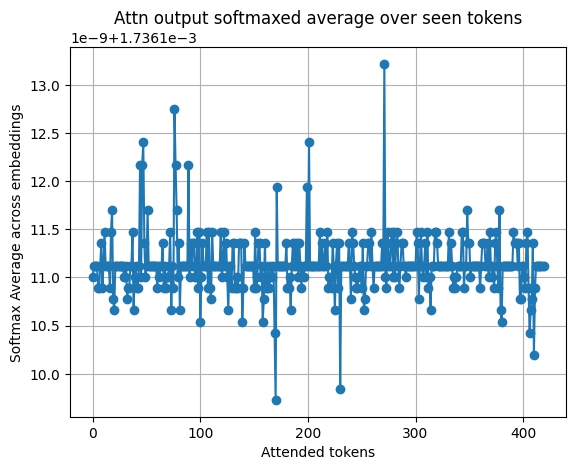

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# attn output mean by axis = 0 so they are all of same length

data = [hooker.cache_output[i][0].squeeze(0).mean(axis=0).softmax(-1).mean().item() for i in range(len(hooker.cache_output))]

# Plotting
plt.plot(data, marker='o')         # Line plot with dots on each point
plt.title("Attn output softmaxed average over seen tokens")
plt.xlabel("Attended tokens")
plt.ylabel("Softmax Average across embeddings")
plt.grid(True)
plt.show()

#### Attn weights (results from hooked)

Expected Behavior of Attention Weights:

	1.	Initially small (e.g., [1, 9, 1, 27])
	2.	Grows as more tokens are processed (L increases)
	3.	Final shape for full attention would be [B, H, L, L]

Attn wegihts != learning weights from the Transformer itself. The returned output alignment scores (after softmax) that tell you: “How much attention should each token give to every other token?”. It is based on the softmaxed formulae / operation in the Attns: 
	•	Q and K (query and key) are computed from the current input (which changes each time).
	•	The softmax output depends entirely on the current token inputs.
	•	So, even if the model is in eval() (inference) mode and weights are frozen, the inputs change, hence attention shifts.

~ “the returned attention weights would be the output against the attention weights”

~ "The returned attn_weights are not trainable parameters but context-sensitive outputs that change depending on the input tokens — even in inference.”


Behavior of its Average (over heads) as it attends more tokens
- lower
- more diverse / distributed (it initiates with a vector of ones then decreases)
Behavior overall as it attends more tokens
- Last dim increases (attended / seen tokens per this current sequence generation 'session')
- Note that you need to apply softmax again to clearly visualize the descending trend, as the raw output decreases with small precision

gpt suggestions (uncomfirmed):
- Early tokens might receive strong attention from the model to maintain contextual coherence.
- Later tokens (in longer sequences) may require more diluted attention, as the context becomes broader and the model must balance attention over a larger set of tokens.
- average attention weights decrease because the model is dispersing attention over a larger sequence of tokens, and the influence of any single token diminishes.
- summary of inference:
	- The increasing number of tokens diluting attention across them.
	- The softmax function normalizing over a larger number of tokens softmax(QK^T) / sqrt(d_k).
	- The multi-head mechanism and the need for heads to capture a wide variety of relationships across the sequence.
	- The shift from highly concentrated attention in early tokens to more evenly distributed attention in longer sequences.


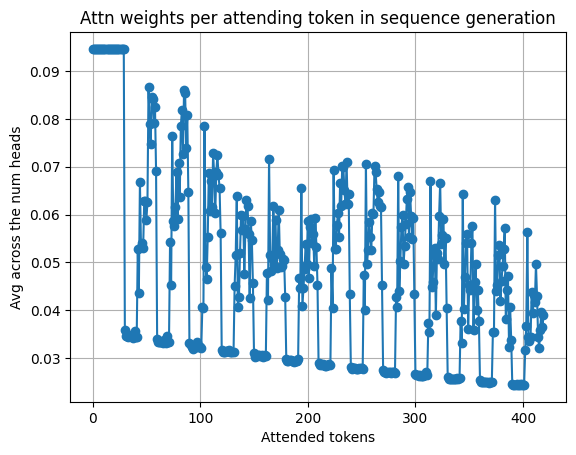

In [9]:
%matplotlib inline

# attn weight mean across [1, 9] (batch_size, num_heads)
# attn weight shape is [1, 9, query_position(?), seq_gen_seen_attending]

#attn_weight = [hooker.cache_output[i][1].squeeze(0).mean(axis=0).softmax(-1).mean().item() for i in range(len(hooker.cache_output))]
attn_weight = [hooker.cache_output[i][1].softmax(-1)[:, :, 0, 0].mean().item() for i in range(len(hooker.cache_output))]

plt.plot(attn_weight, marker='o')         # Line plot with dots on each point
plt.title("Attn weights per attending token in sequence generation")
plt.xlabel("Attended tokens")
plt.ylabel("Avg across the num heads")
plt.grid(True)
plt.show()

In [11]:
def display(vec, x_label: str = 'Attended Tokens', y_label: str = 'Avg'):
    plt.plot(vec, marker='o')         # Line plot with dots on each point
    plt.title("Attn weights per attending token in sequence generation")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

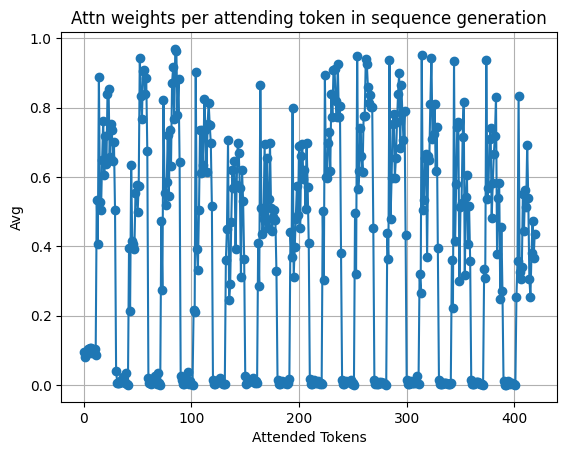

In [13]:
display([hooker.cache_output[i][1][:, :, :, 0].mean().item() for i in range(len(hooker.cache_output))])

In [22]:
[hooker.cache_output[i][1][0, :, :, :].mean().item() for i in range(len(hooker.cache_output))]

[0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703358769417,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703358769417,
 0.03703703731298447,
 0.03703703358769417,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.037037041038274765,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703731298447,
 0.03703703358769417,
 0.0357142873108387,
 0.0357142873108387,
 0.0357142873108387,
 0.035714291036129,
 0.0357142873108387,
 0.0357142873108387,
 0.0357142873108387,
 0.035714291036129,
 0.0357142873108387,
 0.0357142873108387,
 0.0357142835855484,
 0.0357142873108387,
 0.0357142873108387,
 0.0357142873108387,
 0.0357142873108387,
 0.0357142873108387,
 0.03

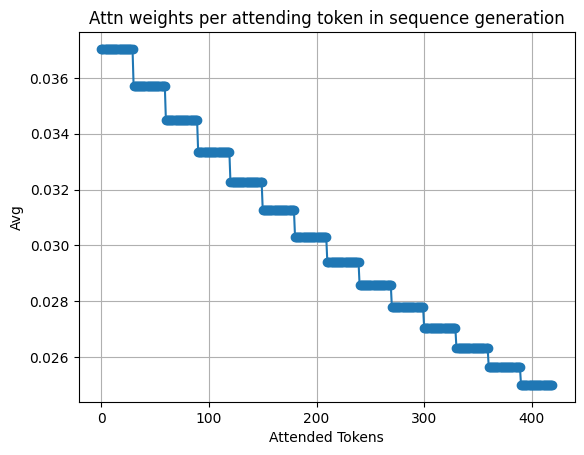

In [21]:
display([hooker.cache_output[i][1][0, :, :, :].mean().item() for i in range(len(hooker.cache_output))])

#### KV Cache Analysis (returned from decoder)

In [62]:
# Length of Key and value caches

print(f"Length of key caches: {len(output.past_key_values.key_cache)}\nLength of value caches: {len(output.past_key_values.value_cache)}")

Length of key caches: 30
Length of value caches: 30


##### Key caches

- Key values length 30 total output (per each block)
- Per block entry is shape: [1, 3, 40, 64]

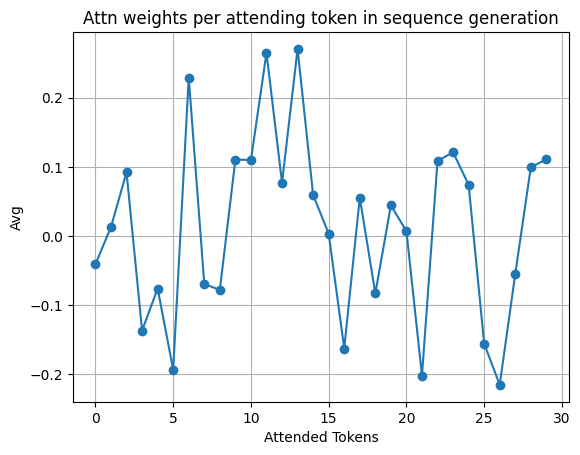

In [69]:
# Approximates around 0.0 due to the initial distribution being ~N(0, 1)

display([i[0, :, :, :].mean().item() for i in output.past_key_values.key_cache])

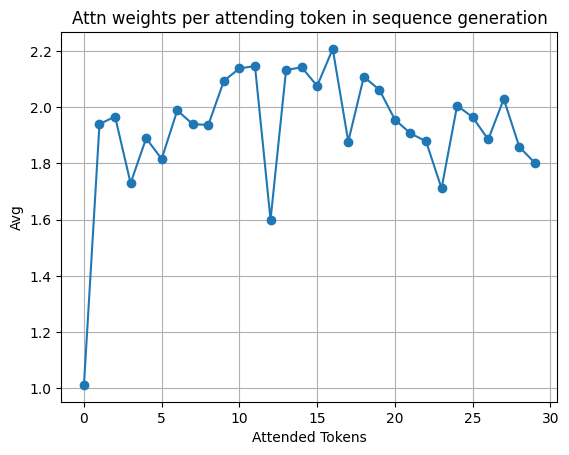

In [70]:
# diverges from 1 (this is because the distribution initiates approx to ~N(0, 1), and iteratively adjusts as the model observes more tokens (or predicts more tokens))
display([i[0, :, :, :].std().item() for i in output.past_key_values.key_cache])

Applying softmax, we can have a more clear view of the trends

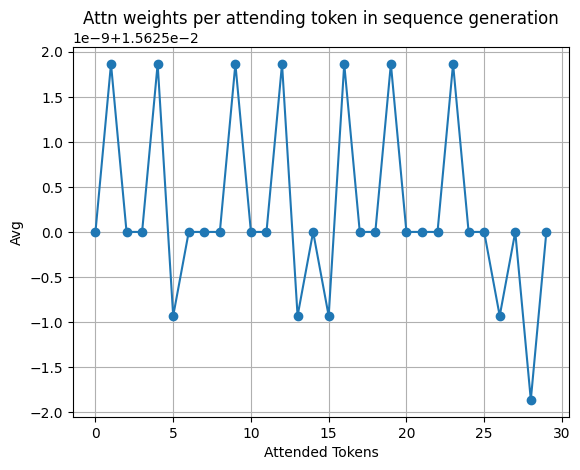

In [83]:
display([i[0, :, :, :].softmax(-1).mean().item() for i in output.past_key_values.key_cache])

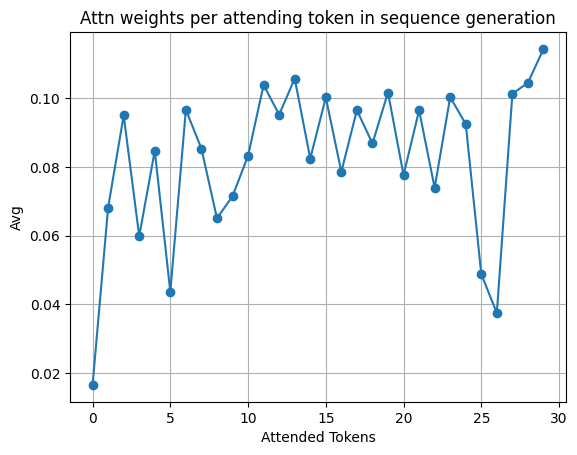

In [84]:
display([i[0, :, :, :].softmax(-1).std().item() for i in output.past_key_values.key_cache])

#### Value Caches

- Value values length 30 total output (per each block)
- Per block entry is shape: [1, 3, 40, 64]

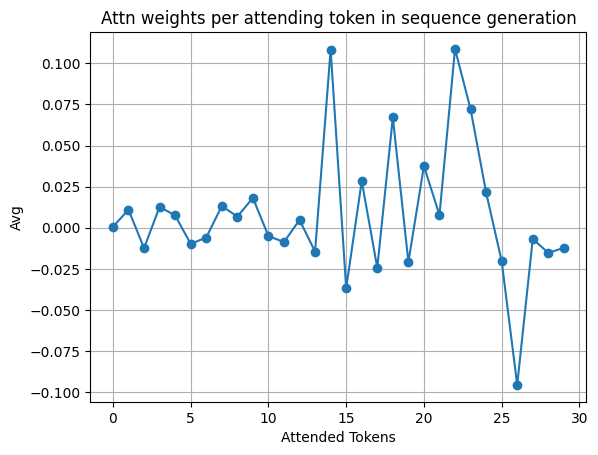

In [79]:
# Approximates around 0.0 due to the initial distribution being ~N(0, 1)

display([i[0, :, :, :].mean().item() for i in output.past_key_values.value_cache])

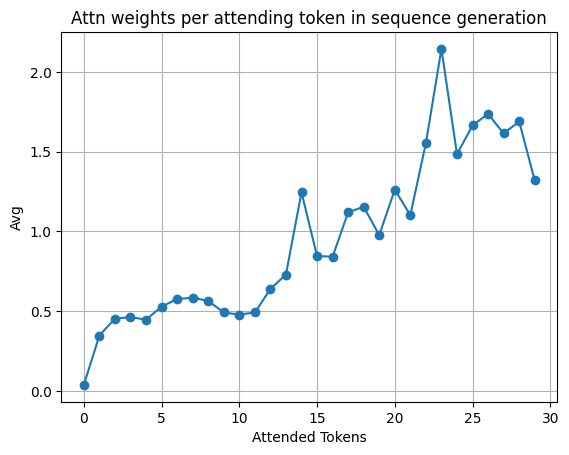

In [82]:
# Standard deviation

display([i[0, :, :, :].std().item() for i in output.past_key_values.value_cache])

If you apply softmax, the trend or pattern is more visible

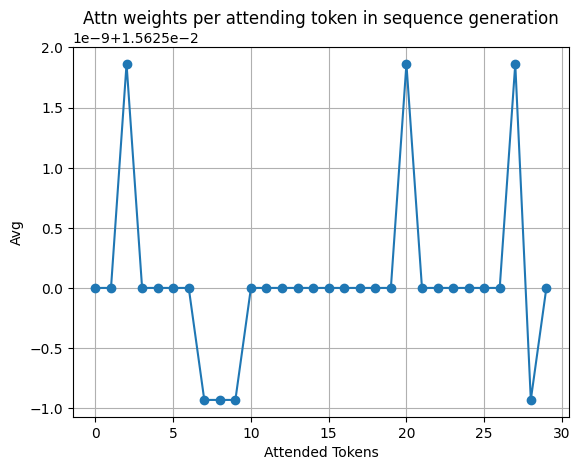

In [80]:

display([i[0, :, :, :].softmax(-1).mean().item() for i in output.past_key_values.value_cache])

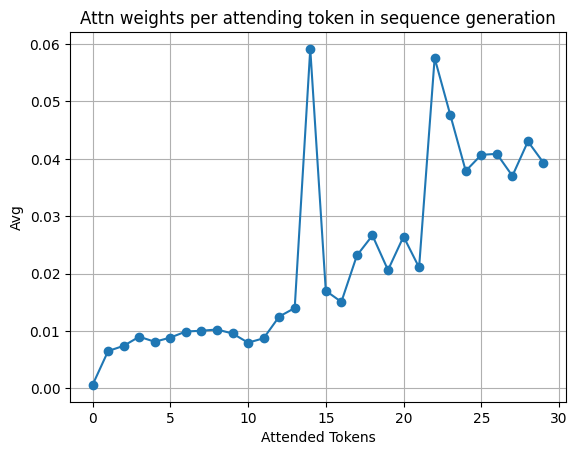

In [81]:

display([i[0, :, :, :].softmax(-1).std().item() for i in output.past_key_values.value_cache])

#### Output Attentions (returned from decoder)

In [ ]:
print(f"Attention for each predicted token, total of {len(output.attentions)}")
print(f"Each entry is of length {len(output.attentions[0])}, the full dimensions per entry:")
[torch.vstack(i).shape for i in output.attentions]

Attention for each predicted token, total of 14
Each entry is of length 30, the full dimensions per entry is:


[torch.Size([30, 9, 27, 27]),
 torch.Size([30, 9, 1, 28]),
 torch.Size([30, 9, 1, 29]),
 torch.Size([30, 9, 1, 30]),
 torch.Size([30, 9, 1, 31]),
 torch.Size([30, 9, 1, 32]),
 torch.Size([30, 9, 1, 33]),
 torch.Size([30, 9, 1, 34]),
 torch.Size([30, 9, 1, 35]),
 torch.Size([30, 9, 1, 36]),
 torch.Size([30, 9, 1, 37]),
 torch.Size([30, 9, 1, 38]),
 torch.Size([30, 9, 1, 39]),
 torch.Size([30, 9, 1, 40])]

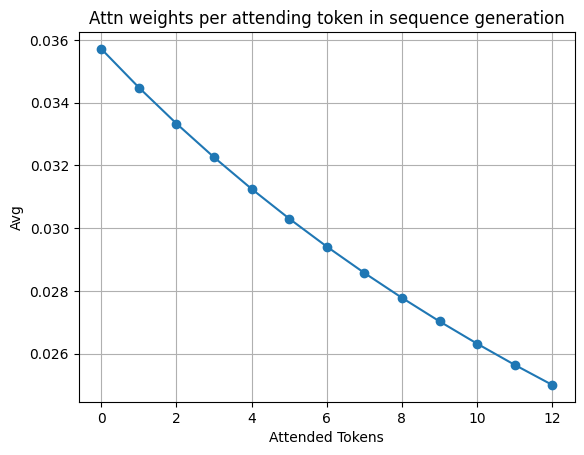

In [99]:
# Ignore the firest entry as this is where the model has not predicted any tokens == 0 state knowledge of sequence generation

display([torch.vstack(i).squeeze(2)[0, 0, :].mean().item() for i in output.attentions[1:]])

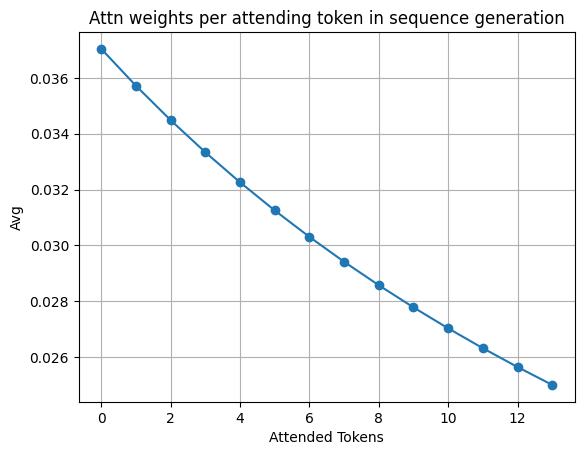

In [111]:
display([torch.vstack(i).squeeze(2)[0, :, :].mean().item() for i in output.attentions])